In [11]:
import graph_characteristics_lib as gc

In [12]:
def bernoulli(p):
    x = randint(0,10^6)
    if x < p*10^6:
        return 1
    else:
        return 0
#change the set V for large graphs
def erdos_renyi_temp(n,tm,p, dire = "d"):
    g = set()
    V = list( [str(i) for i in range(n)] )
    for t in range(1,tm+1):
        for (a,b) in Combinations(V,2):
            if bernoulli(p):
                if bernoulli(0.5):
                    g.add((a,b,t))
                    if dire == "u":
                        g.add((b,a,t))
                        
                else:
                    g.add((b,a,t))
                    if dire == "u":
                        g.add((a,b,t))
                        
                    
    return g

In [29]:
import numpy as np
def temp_to_matrices(g):
    no = gc.nodes(g)
    l_nodes = list(no)
    l_nodes.sort()
    ev = gc.events(g)
    lev = list(ev)
    lev.sort()
    l_inv = { lev[i]:i for i in range(len(lev))  }
#     print("order", l_nodes, lev)
#     t_max = max(gc.events(g))
    res = [  np.matrix([ [0.0 for i in range(len(no))] for j in range(len(no))  ]) for ii in range(len(lev))   ]
    for (a,b,t) in g:
        res[l_inv[t]][l_nodes.index(a),l_nodes.index(b)] = 1.0
        res[l_inv[t]][l_nodes.index(b),l_nodes.index(a)] = 1.0
    return res
from numpy.linalg import inv,eig
import functools
def mats_to_q(mats,alpha=-1):
    rho = max([ max(list(eig(e)[0]))  for e in mats ])
    if alpha == -1:
        alpha = 1/(2*rho)
    id_mat = np.matrix( [   [0.0 if i!=j else 1.0 for j in range(len(mats[0])) ] for i in range(len(mats[0]))  ])
    return functools.reduce(np.matmul,list(map( lambda x : inv(id_mat-alpha*x), mats )))

def mats_to_ev(mats):
    id_mat = np.matrix( [   [0.0 if i!=j else 1.0 for j in range(len(mats[0])) ] for i in range(len(mats[0]))  ])
    return functools.reduce(np.matmul,list(map( lambda x : (id_mat + x).transpose(), mats )))

#at most one link per time
def mats_to_q_variant(mats,alpha=-1):
    rho = max([ max(list(eig(e)[0]))  for e in mats ])
    if alpha == -1:
        alpha = 1/(2*rho)
    id_mat = np.matrix( [   [0.0 if i!=j else 1.0 for j in range(len(mats[0])) ] for i in range(len(mats[0]))  ])
    return functools.reduce(np.matmul,list(map( lambda x : inv(id_mat+alpha*x), mats )))


# def mats_to_q2(mats,alpha=-1):
#     rho = max([ max(list(eig(e)[0]))  for e in mats ])
#     if alpha == -1:
#         alpha = 1/(2*rho)
        
#     id_mat = np.matrix( [   [0 if i!=j else 1 for j in range(len(mats[0])) ] for i in range(len(mats[0]))  ])
#     res = id_mat
#     for i in range(len(mats)):
#         res = np.matmul(res, mats[i])        
#     return res

def mats_eigen(mats):
    return functools.reduce(np.matmul,list(map( lambda x : x.transpose(), mats )))

def mats_auth(mats):
    return functools.reduce(np.matmul,list(map( lambda x : x.transpose()*x, mats )))

def mats_hubs(mats):
    return functools.reduce(np.matmul,list(map( lambda x : x*x.transpose(), mats )))

def equal_vectors(s,s2,quality=100000):
    vs = list(map(lambda x : x[0],s))
    vs2 = list(map(lambda x : x[0],s2))
    if len(vs) != len(vs2):
        return False
    su = 0
    for i in range(len(vs)):
        if abs(vs[i] - vs2[i]) > 1/quality:
            return False
        su += abs(vs[i] - vs2[i])
#     print(su)
    return True

def eigenvalues(g):
    mats = temp_to_matrices(g)
    m = mats_to_q(mats)
    l = list(eig(m)[0])
    l.sort(reverse=True)
    return l

#we should have this
def check_katz(g,g2):
    mats = temp_to_matrices(g)
    mats2 = temp_to_matrices(g2)
    s = mats_to_q(mats).sum(axis=1)
    s2 = mats_to_q(mats2).sum(axis=1)
    b = equal_vectors(s,s2)
    if not b:
        print("prob katz1")
        print(s)
        print(s2)
    return b

def check_katz2(g,g2):
    mats = temp_to_matrices(g)
    mats2 = temp_to_matrices(g2)
    s = mats_to_q(mats).sum(axis=0).transpose()
    s2 = mats_to_q(mats2).sum(axis=0).transpose()
    b = equal_vectors(s,s2)
    if not b:
        print("prob katz2")
        print(s)
        print(s2)
    return b


def katz(g):
    mats = temp_to_matrices(g)
    return mats_to_q(mats).sum(axis=1)

def EV(g):
    mats = temp_to_matrices(g)
    return mats_to_ev(mats).sum(axis=1)
       

def SAE(s,s2):
    l = list(map(lambda x : x[0], s.tolist()))
    l2 = list(map(lambda x : x[0], s2.tolist()))
    val = 0
    for i in range(len(l)):
        val += abs( l[i] - l2[i] )
    return val/len(l)

In [7]:
cmp = 0
n = 40
T = n//2
p = 0.02
for _ in range(50):
    g = erdos_renyi_temp(n,T,p,dire = "u")
    mats = temp_to_matrices(g)
    rho = max([ max(list(eig(e)[0]))  for e in mats ])
    x = mats_to_q(mats,1/(2*rho)).sum(axis=1)
    # print(x,"rho",rho)
    _, col, _, _ = gc.weisfeiler_lehman_graph_hash(g)
    g2 = gc.rewire_any_imp(g ,col,"u", 1000)
    b = check_katz(g,g2)
    if b == False:
        print("prob")
        cmp += 1
print(cmp)

begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iter

In [5]:
mats = temp_to_matrices(g)
rho = max([ max(list(eig(e)[0]))  for e in mats])
print("rho1", rho)
x = mats_to_q(mats,1/(2*2)).sum(axis=1)
mats2 = temp_to_matrices(g2)
rho = max([ max(list(eig(e)[0]))  for e in mats2 ])
print("rho2", rho)
y = mats_to_q(mats2,1/(2*2)).sum(axis=1)
print(x)
print(y)

order ['0', '1', '2', '3', '4'] [1, 2, 3]
rho1 1.414213562373095
order ['0', '1', '2', '3', '4'] [1, 2, 3]
rho2 1.414213562373095
[[1.71428571]
 [1.79047619]
 [1.44761905]
 [1.79047619]
 [1.44761905]]
[[1.71428571]
 [1.79047619]
 [1.44761905]
 [1.79047619]
 [1.44761905]]


In [6]:
col

{('4', 1): 'b2f41f60299bb84fe53a8b732dbab232',
 ('4', 2): 'f32e6e38c1e15d7834b8d68f06ba321a',
 ('4', 3): 'f32e6e38c1e15d7834b8d68f06ba321a',
 ('2', 1): 'b2f41f60299bb84fe53a8b732dbab232',
 ('2', 2): 'b2f41f60299bb84fe53a8b732dbab232',
 ('2', 3): 'f32e6e38c1e15d7834b8d68f06ba321a',
 ('1', 1): 'b33a0ecf44d91131b01a3f27f96f9d9f',
 ('1', 2): '1caa1061b3cc0aa2c103f362e1bb709b',
 ('1', 3): '1caa1061b3cc0aa2c103f362e1bb709b',
 ('0', 1): 'a00b3add608029b40b0b4c8eefc71b9b',
 ('0', 2): 'a00b3add608029b40b0b4c8eefc71b9b',
 ('0', 3): 'a00b3add608029b40b0b4c8eefc71b9b',
 ('3', 1): 'b33a0ecf44d91131b01a3f27f96f9d9f',
 ('3', 2): 'b33a0ecf44d91131b01a3f27f96f9d9f',
 ('3', 3): '1caa1061b3cc0aa2c103f362e1bb709b'}

In [7]:
_, col2, _, _ = gc.weisfeiler_lehman_graph_hash(g2)
col2

begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4


{('4', 1): 'b2f41f60299bb84fe53a8b732dbab232',
 ('4', 2): 'f32e6e38c1e15d7834b8d68f06ba321a',
 ('4', 3): 'f32e6e38c1e15d7834b8d68f06ba321a',
 ('2', 1): 'b2f41f60299bb84fe53a8b732dbab232',
 ('2', 2): 'b2f41f60299bb84fe53a8b732dbab232',
 ('2', 3): 'f32e6e38c1e15d7834b8d68f06ba321a',
 ('1', 1): 'b33a0ecf44d91131b01a3f27f96f9d9f',
 ('1', 2): '1caa1061b3cc0aa2c103f362e1bb709b',
 ('1', 3): '1caa1061b3cc0aa2c103f362e1bb709b',
 ('0', 1): 'a00b3add608029b40b0b4c8eefc71b9b',
 ('0', 2): 'a00b3add608029b40b0b4c8eefc71b9b',
 ('0', 3): 'a00b3add608029b40b0b4c8eefc71b9b',
 ('3', 1): 'b33a0ecf44d91131b01a3f27f96f9d9f',
 ('3', 2): 'b33a0ecf44d91131b01a3f27f96f9d9f',
 ('3', 3): '1caa1061b3cc0aa2c103f362e1bb709b'}

In [8]:
gc.check_convergence_node_labels(col, col2)

True

In [36]:
import math
N = 120
# gap = 5
repet = 5
direc = "u"
d = dict()
dep = 10
n = N
T = n//2
p = 2/(n*T)
for j in range(1,repet+1):
    g = erdos_renyi_temp(n,T,p,dire = direc)
    s = katz(g)
    _, col, keep, nb_con = gc.weisfeiler_lehman_graph_hash(g, keep_iterations = True)
    d[j] = dict()
    m = max(keep.keys())
    for i in range(0,dep + 1):
        if i == 0:
            g2 = gc.rewire_any(g,len(g)*math.ceil(math.log(len(g))),{ (v,t):1 for v in gc.nodes(g) for t in gc.events(g) },direc)
        elif i > m:
            g2 = gc.rewire_any(g,len(g)*math.ceil(math.log(len(g))),keep[m],direc)
            check_katz(g,g2)
        else:
            g2 = gc.rewire_any(g,len(g)*math.ceil(math.log(len(g))),keep[i],direc)
        s2 = katz(g2)
        d[j][i] = SAE(s,s2)

begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6


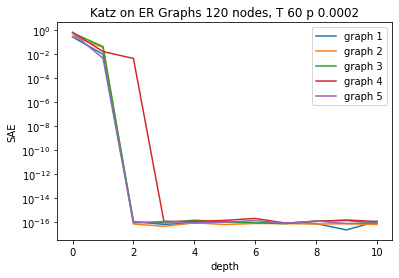

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# evenly sampled time at 200ms intervals
x = [  de for de in range(0,dep+1) ]
x.sort()
y = dict()

for n in d.keys():
    for de in d[n].keys():
        if n not in y:
            y[n] = []
        y[n].append(d[n][de])
        
# red dashes, blue squares and green triangles
for n in y.keys():
    plt.plot(x,y[n],label='graph '+str(n))
plt.yscale("log")
plt.xlabel("depth")
plt.ylabel("SAE")
plt.title('Katz on ER Graphs '+str(N)+' nodes, T '+ str(T)+' p '+str(float(p))[:6])
plt.legend()
plt.savefig('katz.png', dpi=300)
plt.show()

In [38]:
import math
N = 120
# gap = 5
repet = 5
direc = "u"
d = dict()
dep = 10
n = N
T = n//2
p = 2/(n*T)
for j in range(1,repet+1):
    g = erdos_renyi_temp(n,T,p,dire = direc)
    s = EV(g)
    _, col, keep, nb_con = gc.weisfeiler_lehman_graph_hash(g, keep_iterations = True)
    d[j] = dict()
    m = max(keep.keys())
    for i in range(0,dep + 1):
        if i == 0:
            g2 = gc.rewire_any(g,len(g)*math.ceil(math.log(len(g))),{ (v,t):1 for v in gc.nodes(g) for t in gc.events(g) },direc)
        elif i > m:
            g2 = gc.rewire_any(g,len(g)*math.ceil(math.log(len(g))),keep[m],direc)
        else:
            g2 = gc.rewire_any(g,len(g)*math.ceil(math.log(len(g))),keep[i],direc)
        s2 = EV(g2)
#         if i > m:
#             print(equal_vectors(s,s2))
        d[j][i] = SAE(s,s2)

begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
begin all neigbour
end all neigbour
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7


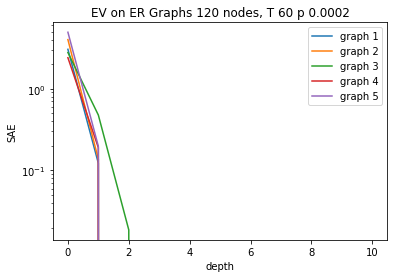

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# evenly sampled time at 200ms intervals
x = [  de for de in range(0,dep+1) ]
x.sort()
y = dict()

for n in d.keys():
    for de in d[n].keys():
        if n not in y:
            y[n] = []
        y[n].append(d[n][de])
        
# red dashes, blue squares and green triangles
for n in y.keys():
    plt.plot(x,y[n],label='graph '+str(n))
plt.yscale("log")
plt.xlabel("depth")
plt.ylabel("SAE")
plt.title('EV on ER Graphs '+str(N)+' nodes, T '+ str(T)+' p '+str(float(p))[:6])
plt.legend()
plt.savefig('EV.png', dpi=300)
plt.show()